In [44]:
"""
Data augmentation for aphasic text generation
authors:
    Damiano Pasquini damiano23@ru.is
    Andrea Terenziani andrea23@ru.is
    Aurora Ayn Wickstrom aurora23@ru.is
course: T-725-MALV, Málvinnsla
"""

import pandas as pd
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords, gutenberg

In [45]:
nltk.download('gutenberg', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [46]:
random_state = 111111
rnd.seed(random_state)

In [47]:
def histplot(df: pd.DataFrame, bins=60, column=None, xlabel=None, ylabel="Frequency", title=None, **plot_args):
    """
    Plot a histogram of the given column of the given dataframe
    """
    if column is None:
        column = df.columns[0]

    if xlabel is None:
        xlabel = column

    if title is None:
        title = f'Distribution of {column}'

    # Create a histogram to visualize the distribution of sentence lengths
    plt.hist(df[column], bins=bins, **plot_args)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [48]:
df = pd.read_csv("eng_sents.csv", names=["sentences"])
df.describe()

,sentences
count,28806
unique,28806
top,Children who spend more time outdoors have a l...
freq,1


## Preprocessing

The longest (by number of words) sentences are unrealistic so we do a two-step filter:

1. Remove sentences longer than some fixed threshold $L_{max} := 400$ 
2. Of those remaining, keep only those who are in the $p := 0.8$ fraction closest to the median
3. Of those remaining, keep a randomly selected subset of size $s := 4000$

In [49]:
df["sent-len"] = df["sentences"].apply(len)
df["sent-len"].describe()

count    28806.000000
mean        74.371589
std         64.679002
min          3.000000
25%         30.000000
50%         48.000000
75%        103.000000
max        855.000000
Name: sent-len, dtype: float64

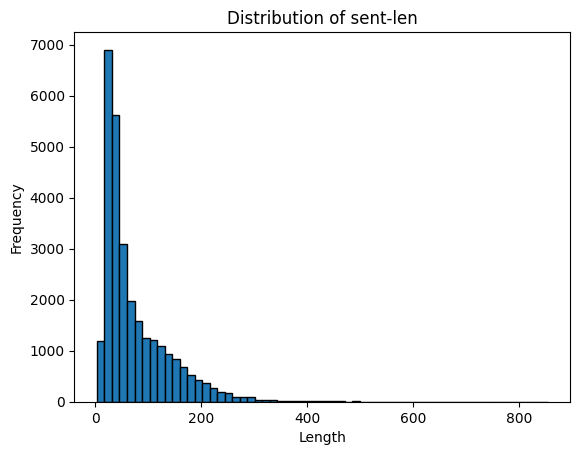

In [50]:
histplot(df, column="sent-len", xlabel="Length", edgecolor="k")

In [51]:
Lmin = 2
Lmax = 30
df1 = df[df["sent-len"].between(Lmin, Lmax, inclusive="both")]

In [52]:
df1["sent-len"].describe()

count    7580.000000
mean       22.861873
std         4.953943
min         3.000000
25%        19.000000
50%        23.000000
75%        27.000000
max        30.000000
Name: sent-len, dtype: float64

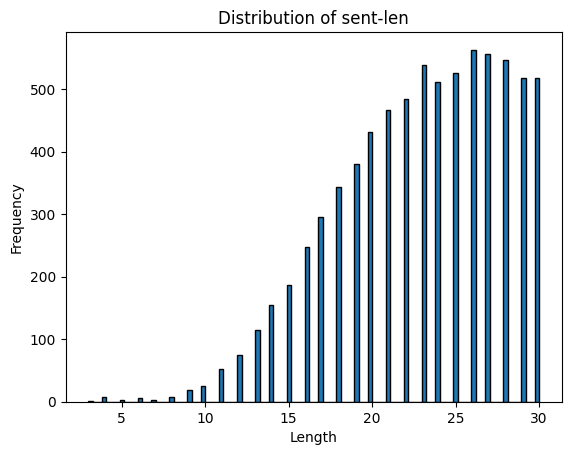

In [53]:
histplot(df1, bins=100, column="sent-len", xlabel="Length", edgecolor="k")

In [54]:
p=1.0 # previously 0.8
total_left = len(df1)
to_extract = int(p * total_left)

med_len = df1["sent-len"].median()
df1['len-diff'] = abs(df1['sent-len'] - med_len)
df2 = df1.sort_values(by="len-diff").head(n=to_extract)

len(df2)

C:\Users\pasqu\AppData\Local\Temp\ipykernel_23708\4082126998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['len-diff'] = abs(df1['sent-len'] - med_len)


7580

In [55]:
df2["sent-len"].describe()

count    7580.000000
mean       22.861873
std         4.953943
min         3.000000
25%        19.000000
50%        23.000000
75%        27.000000
max        30.000000
Name: sent-len, dtype: float64

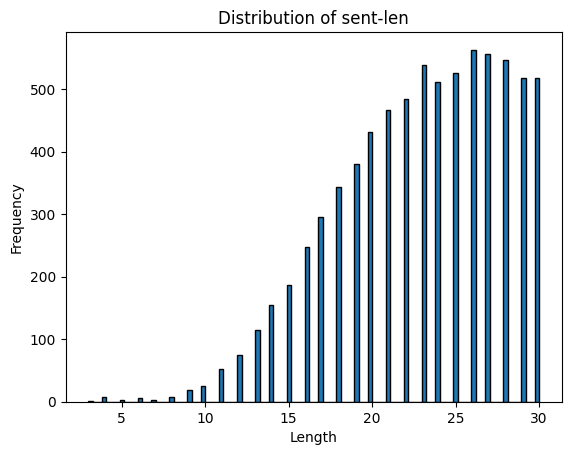

In [56]:
histplot(df2, bins=100, column="sent-len", xlabel="Length", edgecolor="k")

In [57]:
data = df2["sentences"].sample(n=4000, random_state=random_state).to_frame()
# data = df2["sentences"].sample(n=4000, random_state=random_state).to_frame()
data.describe()

,sentences
count,4000
unique,4000
top,I may need to see the booty.
freq,1


In [58]:
data.head()

,sentences
16610,I may need to see the booty.
7473,Tom isn't Australian.
15390,I cry every time.
1708,He's probably exaggerating.
17674,Give me your credit card.


## (pseudo-)Aphasic text generation

### N-gram model

Creation of an n-gram character LM from text for word variant scoring

In [59]:
src_title = "melville-moby_dick.txt"

In [60]:
source_sents = gutenberg.sents(src_title)
source_sents = [[c for w in s for c in w] for s in source_sents]

print(*source_sents[:10], sep="\n")

['[', 'M', 'o', 'b', 'y', 'D', 'i', 'c', 'k', 'b', 'y', 'H', 'e', 'r', 'm', 'a', 'n', 'M', 'e', 'l', 'v', 'i', 'l', 'l', 'e', '1', '8', '5', '1', ']']
['E', 'T', 'Y', 'M', 'O', 'L', 'O', 'G', 'Y', '.']
['(', 'S', 'u', 'p', 'p', 'l', 'i', 'e', 'd', 'b', 'y', 'a', 'L', 'a', 't', 'e', 'C', 'o', 'n', 's', 'u', 'm', 'p', 't', 'i', 'v', 'e', 'U', 's', 'h', 'e', 'r', 't', 'o', 'a', 'G', 'r', 'a', 'm', 'm', 'a', 'r', 'S', 'c', 'h', 'o', 'o', 'l', ')']
['T', 'h', 'e', 'p', 'a', 'l', 'e', 'U', 's', 'h', 'e', 'r', '-', '-', 't', 'h', 'r', 'e', 'a', 'd', 'b', 'a', 'r', 'e', 'i', 'n', 'c', 'o', 'a', 't', ',', 'h', 'e', 'a', 'r', 't', ',', 'b', 'o', 'd', 'y', ',', 'a', 'n', 'd', 'b', 'r', 'a', 'i', 'n', ';', 'I', 's', 'e', 'e', 'h', 'i', 'm', 'n', 'o', 'w', '.']
['H', 'e', 'w', 'a', 's', 'e', 'v', 'e', 'r', 'd', 'u', 's', 't', 'i', 'n', 'g', 'h', 'i', 's', 'o', 'l', 'd', 'l', 'e', 'x', 'i', 'c', 'o', 'n', 's', 'a', 'n', 'd', 'g', 'r', 'a', 'm', 'm', 'a', 'r', 's', ',', 'w', 'i', 't', 'h', 'a', 'q', 

In [61]:
# Create an N-gram model of the source text
from nltk.lm.preprocessing import padded_everygram_pipeline

n_gram_size = 4

train, vocab = padded_everygram_pipeline(n_gram_size, source_sents)

In [62]:
from nltk.lm.smoothing import Smoothing

#TODO: Actually implement Katz smoothing (somehow)
class KatzSmoothing(Smoothing):
    def __init__(self, vocabulary, count, gamma=0.5):
        super().__init__(vocabulary, count)
        self.gamma = gamma

    def unigram_score(self, word, context=None):
        return self.gamma / self.counts[0]

    def alpha_gamma(self, word, context):
        return self.gamma

    def discount(self):
        return self.gamma

    def __str__(self):
        return f"KatzSmoothing(gamma={self.gamma})"

In [63]:
from nltk.lm import MLE

mle = MLE(n_gram_size)

In [64]:
mle.fit(text=train, vocabulary_text=vocab)

In [65]:
mle.generate(5)

['c', 'a', 'l', 'l', 'd']

### Data generation

In [66]:
def insert_rand_char(word, charset=string.ascii_lowercase):
    l = len(word)
    idx = rnd.randint(l)
    char_idx = rnd.randint(len(charset))
    char = charset[char_idx]

    return f"{word[:idx]}{char}{word[idx:]}"

def delete_rand_char(word):
    l = len(word)
    idx = rnd.randint(l)

    return f"{word[:idx]}{word[idx+1:]}"

def swap_rand_chars(word):
    word = word.removesuffix(".").removesuffix(",").removesuffix(";").removesuffix(":").removesuffix("!").removesuffix("?").removesuffix("'").removesuffix('"').removeprefix("'").removeprefix('"')
    
    l = len(word)
    if l < 2:
        return word

    idx1, idx2 = sorted(rnd.choice(range(l), size=2, replace=False))
    
    c1, c2 = word[idx1], word[idx2]

    return f"{word[:idx1]}{c2}{word[idx1+1:idx2]}{c1}{word[idx2+1:]}"

def alter_word(word, n_changes=1):
    changes = rnd.choice(["I", "D", "S"], size=n_changes)
    iscapitalized = word[0].isupper()

    output = word
    for i in range(n_changes):
        if changes[i] == "I":
            output = insert_rand_char(output)
        elif changes[i] == "D":
            output = delete_rand_char(output)
        elif changes[i] == "S":
            output = swap_rand_chars(output)
            
    if iscapitalized:
        output = output.capitalize()

    return output

In [67]:
alter_word("ciaone")

'ciaon'

In [68]:
def score_variant(variant, context):
    variant_chars = [c for c in variant]
    context_chars = [c for c in context]

    """scores = [mle.logscore(vc, cc) for vc, cc in zip(variant_chars, context_chars)]

    return sum(scores) / len(variant)"""

    return mle.logscore(variant_chars, context_chars)

def get_best_variant(word, context, var_count=10, max_iter=20):
    variants = [""] * var_count
    scores = [0.] * var_count

    for i in range(var_count):
        for _ in range(max_iter):
            new_var = alter_word(word)
            if not new_var in variants:
                variants[i] = new_var
                scores[i] = score_variant(new_var, context)
                break

    selected = np.argmax(scores)

    return variants[selected]

def alter_sentence(sent, p=0.4, ng_size = n_gram_size, var_count=10):
    output = ""
    #TODO: Should probably tokenize better with nltk instead of just splitting on spaces
    words = sent.split(" ")
    current_idx = 0

    for idx, w in enumerate(words):
        current_idx += len(w)
        # Unless it's the last word, add a space
        if idx < len(words) - 1:
            current_idx += 1

        w2 = w

        if rnd.rand() < p:
            # Pass as context the previous 2 characters in sent
            start = max(0, current_idx - ng_size)
            context = sent[start:current_idx]

            w2 = get_best_variant(w, context=context, var_count=var_count)

        output += f"{w2} "

    return output.strip() # remove trailing whitespace

In [69]:
alter_sentence("how is it going big guy")

'how iqs it ggino lbig guy'

In [70]:
data_altered = data.copy()

In [71]:
data_altered["sents-alt"] = data_altered["sentences"].apply(alter_sentence)
with open('eng_sents_altered.txt', 'w', encoding='utf-8') as file:
    for index, row in data_altered.iterrows():
        file.write(f"{row['sents-alt']}\t{row['sentences']}\n")
# # save to csv
# data_altered.to_csv("eng_sents_altered.txt", index=False, header=False)

In [72]:
data_altered.head()

,sentences,sents-alt
16610,I may need to see the booty.,I may tneed to see vthe booty.
7473,Tom isn't Australian.,To is't Australian.
15390,I cry every time.,I cry very time.
1708,He's probably exaggerating.,He's probably exaggerating.
17674,Give me your credit card.,Lgive em your credgit card.
